In [27]:
import pandas as pd
import numpy as np

In [28]:
df_train = pd.read_csv('./datasets/train.csv')
df_test = pd.read_csv('./datasets/test.csv')

In [29]:
df_train.head(10)

,id,title,description,project,storypoint
0,5660,Error enabling Appcelerator services during ap...,"When creating the default app, I encountered t...",project8,3
1,9014,Create a maintenance branch,"As a developer, I'd like to have a maintenance...",project6,5
2,4094,Service Activity Monitoring Backend integrated...,SAM API used by SAM GUI,project1,5
3,811,fs::enter(rootfs) does not work if 'rootfs' is...,I noticed this when I was testing the unified ...,project5,2
4,4459,transform processor with script option is broken,Creating the following stream throws exception...,project6,2
5,8896,Service Registry: REST endpoints URL renaming,Endpoint URLs of Service Registry REST service...,project1,1
6,2304,TiStudio: Projects - A pane is missing when cr...,Details: If you try to create the default Tita...,project8,5
7,9192,Avoid installing test and performance services...,The membership plans are associated with organ...,project8,5
8,1888,Add Unit Tests for CC SPI infrastructure,"Test Converter, Configuration, Definition and ...",project6,3
9,4609,Agent should not return partial state when a r...,Currently when a user is hitting /state.json o...,project5,3


# Análisis Exploratorio de Datos

## Exploración Inicial

In [30]:
df_train.shape

(7900, 5)

In [31]:
print(df_train.columns.values)

['id' 'title' 'description' 'project' 'storypoint']


In [32]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7900 entries, 0 to 7899
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           7900 non-null   int64 
 1   title        7900 non-null   object
 2   description  7900 non-null   object
 3   project      7900 non-null   object
 4   storypoint   7900 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 308.7+ KB


In [33]:
df_train['storypoint'].unique()

array([ 3,  5,  2,  1,  8, 13,  4, 40,  6, 20, 10, 15, 32, 12, 16, 21, 34,
       14, 24,  7], dtype=int64)

In [34]:
df_train.duplicated().sum()

0

In [35]:
df_train.isnull().sum()

id             0
title          0
description    0
project        0
storypoint     0
dtype: int64

In [36]:
df_train.describe()

,id,storypoint
count,7900.000000,7900.000000
mean,4951.059620,3.885190
std,2853.243052,3.027804
min,1.000000,1.000000
25%,2475.750000,2.000000
50%,4970.500000,3.000000
75%,7413.250000,5.000000
max,9874.000000,40.000000


In [37]:
df_train["storypoint"].value_counts()

storypoint
3     1848
5     1693
1     1629
2     1276
8     1025
4      166
13     154
10      32
20      31
6       17
16       7
12       6
40       5
21       3
15       2
7        2
32       1
34       1
14       1
24       1
Name: count, dtype: int64

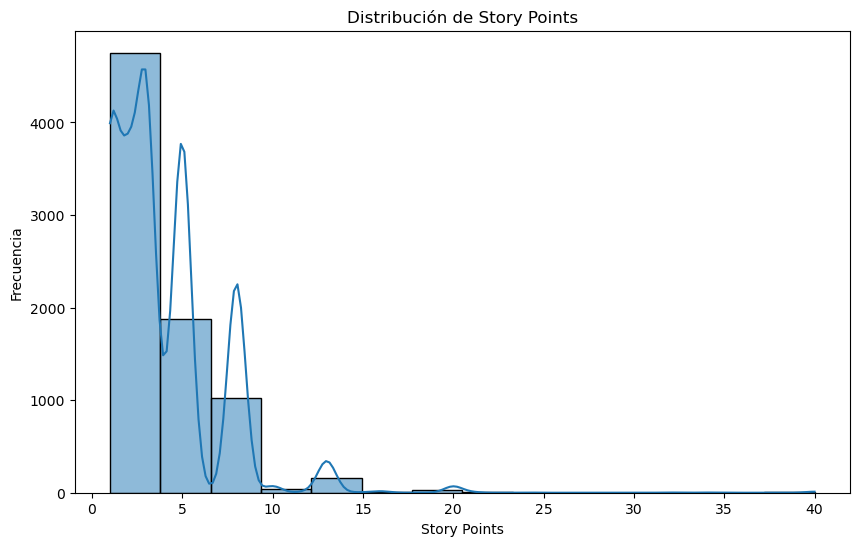

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histograma de Story Points
plt.figure(figsize=(10, 6))
sns.histplot(df_train['storypoint'], bins=14, kde=True)
plt.title('Distribución de Story Points')
plt.xlabel('Story Points')
plt.ylabel('Frecuencia')
plt.show()

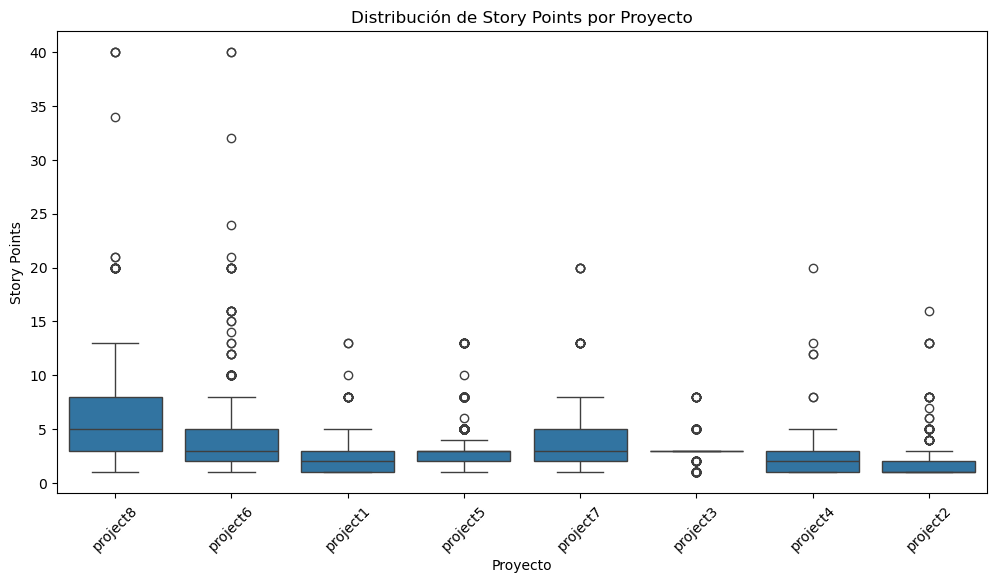

In [39]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='project', y='storypoint', data=df_train)
plt.title('Distribución de Story Points por Proyecto')
plt.xlabel('Proyecto')
plt.ylabel('Story Points')
plt.xticks(rotation=45)
plt.show()

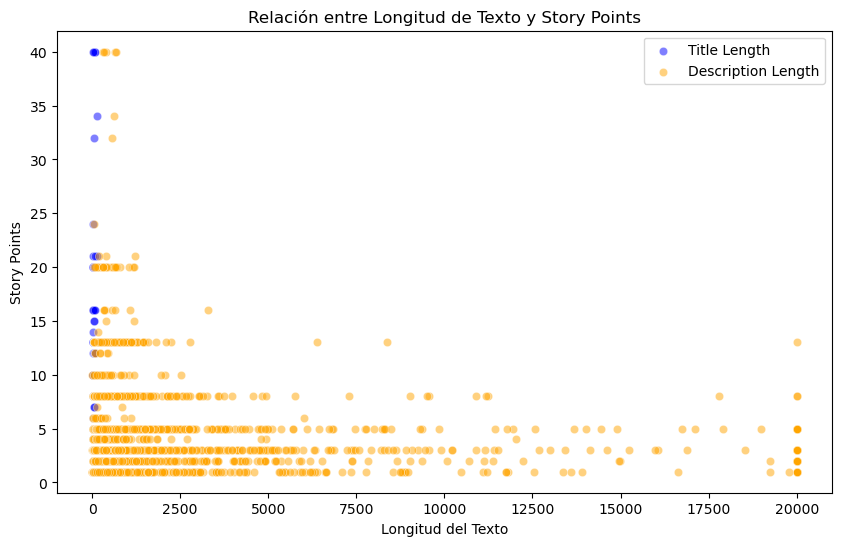

In [40]:
# Añadir longitud de título y descripción
df_train['title_length'] = df_train['title'].apply(len)
df_train['description_length'] = df_train['description'].apply(len)

# Gráfico de dispersión
plt.figure(figsize=(10, 6))
sns.scatterplot(x='title_length', y='storypoint', data=df_train, color='blue', alpha=0.5, label='Title Length')
sns.scatterplot(x='description_length', y='storypoint', data=df_train, color='orange', alpha=0.5, label='Description Length')
plt.title('Relación entre Longitud de Texto y Story Points')
plt.xlabel('Longitud del Texto')
plt.ylabel('Story Points')
plt.legend()
plt.show()


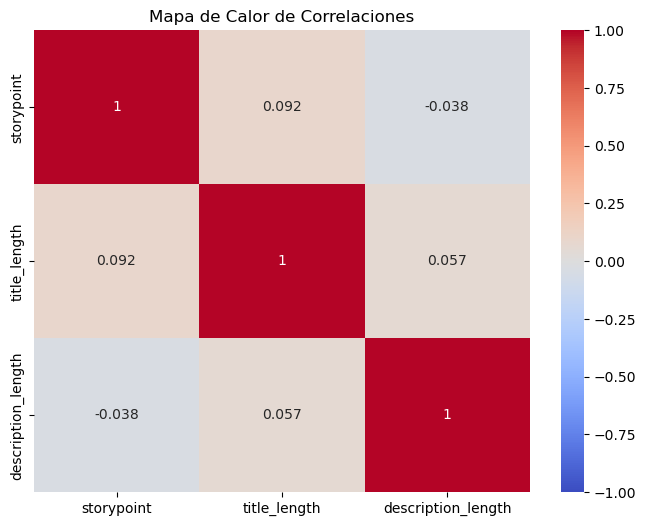

In [41]:
import numpy as np

# Mapa de calor de correlaciones
plt.figure(figsize=(8, 6))
sns.heatmap(df_train[['storypoint', 'title_length', 'description_length']].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Mapa de Calor de Correlaciones')
plt.show()


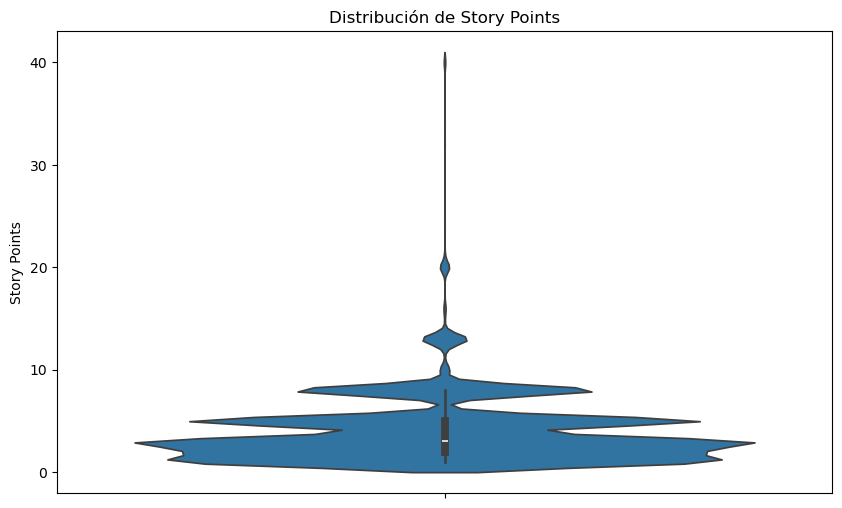

In [42]:
plt.figure(figsize=(10, 6))
sns.violinplot(y='storypoint', data=df_train)
plt.title('Distribución de Story Points')
plt.ylabel('Story Points')
plt.show()


# Preprocesamiento de datos

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


#from category_encoders import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

# Importar modelos
from sklearn.linear_model import LinearRegression

# Importar métricas
from sklearn.metrics import root_mean_squared_error

from category_encoders import BinaryEncoder

In [44]:
from scripts.functions import *

# Modelos

Modelos a entrenar:
- Baseline: Regresión Lineal
- Bayes Naive
- Random Forest
- XGBoost
- Red Neuronal (Keras y Tensorflow)
- Ensamble (3 modelos)

Se utilizará el mismo preprocesamiento del dataset para cada uno de los modelos.

## Preprocesamiento de datos

In [45]:
X = df_train[['title', 'description', 'project']]
y = df_train['storypoint']

X_train_unprocessed, X_test_unprocessed, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [46]:
preprocessor = ColumnTransformer(
    transformers=[
        ('title_bow', TfidfVectorizer(max_features=300, stop_words='english', ngram_range=(1, 2)), 'title'), # Vectorización de 'title'
        ('description_bow', TfidfVectorizer(max_features=300, stop_words='english', ngram_range=(1, 2)), 'description'), # Vectorización de 'description'
        ('project_ohe', BinaryEncoder(), ['project']), #OneHotEncoder(drop='first'), ['project']) # One-hot encoding de 'project'
    ]
)

In [47]:
X_train  = preprocessor.fit_transform(X_train_unprocessed)
X_test  = preprocessor.transform(X_test_unprocessed)

test = preprocessor.transform(df_test[['title', 'description', 'project']])

In [48]:
X_train.shape, X_test.shape, test.shape

((6320, 604), (1580, 604), (1975, 604))

## Baseline: LinearRegression

In [49]:
model_lr = LinearRegression()

param_dist_lr = {
    'fit_intercept': [True, False],
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

random_search_lr = RandomizedSearchCV(
    model_lr, 
    param_distributions=param_dist_lr, 
    n_iter=2,
    scoring='neg_root_mean_squared_error', 
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

In [50]:
%%time
random_search_lr.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
CPU times: total: 172 ms
Wall time: 1.33 s


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=LinearRegression(), n_iter=2, n_jobs=-1,
                   param_distributions={'fit_intercept': [True, False]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [51]:
# Mejor RMSE y parámetros
print(f'Mejor RMSE: {-random_search_lr.best_score_}') # Es un promedio de 5 scores diferentes (porque cv=5)
print(f'Mejores hiperparámetros: {random_search_lr.best_params_}\n')

# Conjunto train
y_pred_train = random_search_lr.best_estimator_.predict(X_train)
rmse_train = root_mean_squared_error(y_train, y_pred_train)
print(f'RMSE en el conjunto de train: {rmse_train}')

# Conjunto prueba
y_pred_test = random_search_lr.best_estimator_.predict(X_test)
rmse_test = root_mean_squared_error(y_test, y_pred_test)
print(f'RMSE en el conjunto de prueba: {rmse_test}\n')

Mejor RMSE: 2.8175592013159134
Mejores hiperparámetros: {'fit_intercept': True}

RMSE en el conjunto de train: 2.511256377597955
RMSE en el conjunto de prueba: 2.529648394697759



### Guardamos resultados en JSON

In [52]:
results_rl = {
    'model': 'LinearRegression',
    'best_params': random_search_lr.best_params_,
    'best_score': -random_search_lr.best_score_,
    'rmse_train': rmse_train,
    'rmse_test': rmse_test
}

save_model_results(results_rl)

### Submision Baseline Regresión Lineal

In [53]:
y_pred = random_search_lr.best_estimator_.predict(test)
submission_test = pd.DataFrame({'id': df_test['id'], 'storypoint': y_pred})
submission_test.to_csv('./submission/submission_linear_regression.csv', index=False)

## Bayes Naive

In [54]:
from sklearn.naive_bayes import MultinomialNB

In [55]:
model_nb = MultinomialNB()

param_dist_nb = {
    # Hiperparámetros de MultinomialNB
    'alpha': np.linspace(0.1, 1.0, num=10),
    'fit_prior': [True, False]
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

random_search_nb = RandomizedSearchCV(
    model_nb, 
    param_distributions=param_dist_nb, 
    n_iter=20,
    scoring='neg_root_mean_squared_error', 
    cv=cv, 
    n_jobs=-1,
    verbose=2,
    random_state=42
)

In [56]:
%%time
random_search_nb.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
CPU times: total: 46.9 ms
Wall time: 278 ms


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=MultinomialNB(), n_iter=20, n_jobs=-1,
                   param_distributions={'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'fit_prior': [True, False]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [57]:
# Mejor RMSE y parámetros
print(f'Mejor RMSE: {-random_search_nb.best_score_}')  # Promedio de 5 scores (porque cv=5)
print(f'Mejores hiperparámetros: {random_search_nb.best_params_}\n')

# Conjunto train
y_pred_train = random_search_nb.best_estimator_.predict(X_train)
rmse_train = root_mean_squared_error(y_train, y_pred_train)
print(f'RMSE en el conjunto de train: {rmse_train}\n')

# Conjunto prueba
y_pred_test = random_search_nb.best_estimator_.predict(X_test)
rmse_test = root_mean_squared_error(y_test, y_pred_test)
print(f'RMSE en el conjunto de prueba: {rmse_test}')

Mejor RMSE: 3.0708085073870266
Mejores hiperparámetros: {'fit_prior': True, 'alpha': 0.1}

RMSE en el conjunto de train: 2.933789401638188

RMSE en el conjunto de prueba: 2.8741537004257247


#### Guardamos resultados en JSON

In [58]:
results_nb = {
    'model': 'MultinomialNB',
    'best_params': random_search_nb.best_params_,
    'best_score': -random_search_nb.best_score_,
    'rmse_train': rmse_train,
    'rmse_test': rmse_test
}

save_model_results(results_nb)

#### Submision Bayes Naive

In [59]:
y_pred = random_search_nb.best_estimator_.predict(test)
submission_test = pd.DataFrame({'id': df_test['id'], 'storypoint': y_pred})

submission_test.to_csv('./submission/submission_multinomial_nb.csv', index=False)

## Random Forest

In [60]:
from sklearn.ensemble import RandomForestRegressor

In [61]:
model_rf = RandomForestRegressor()

param_dist_rf = {
    # Hiperparámetros de RandomForestRegressor
    'n_estimators': [20, 50, 80, 100, 200],  # Número de árboles
    'max_depth': [3, 5, 8, 10, 20, 30, 50, 100],  # Profundidad máxima
    'min_samples_split': [2, 5, 10],  # Mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],  # Mínimo de muestras en una hoja
    'bootstrap': [True, False]  # Muestreo con reemplazo
}

cv = KFold(n_splits=3, shuffle=True, random_state=42)

random_search_rf = RandomizedSearchCV(
    model_rf, 
    param_distributions=param_dist_rf, 
    n_iter=10,
    scoring='neg_root_mean_squared_error', 
    cv=cv, 
    n_jobs=-1,
    verbose=2,
    random_state=42
)

In [62]:
%%time
random_search_rf.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
CPU times: total: 11.2 s
Wall time: 52.1 s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [3, 5, 8, 10, 20, 30, 50,
                                                      100],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [20, 50, 80, 100, 200]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [63]:
# Mejor RMSE y parámetros
print(f'Mejor RMSE: {-random_search_rf.best_score_}')  # Promedio de 5 scores (porque cv=5)
print(f'Mejores hiperparámetros: {random_search_rf.best_params_}\n')

# Conjunto train
y_pred_train = random_search_rf.best_estimator_.predict(X_train)
rmse_train = root_mean_squared_error(y_train, y_pred_train)
print(f'RMSE en el conjunto de train: {rmse_train}\n')

# Conjunto prueba
y_pred_test = random_search_rf.best_estimator_.predict(X_test)
rmse_test = root_mean_squared_error(y_test, y_pred_test)
print(f'RMSE en el conjunto de prueba: {rmse_test}')

Mejor RMSE: 2.7142134794509154
Mejores hiperparámetros: {'n_estimators': 80, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 50, 'bootstrap': True}

RMSE en el conjunto de train: 1.56703016366774

RMSE en el conjunto de prueba: 2.40780782956182


In [64]:
results_rf = {
    'model': 'RandomForestRegressor',
    'best_params': random_search_rf.best_params_,
    'best_score': -random_search_rf.best_score_,
    'rmse_train': rmse_train,
    'rmse_test': rmse_test
}

save_model_results(results_rf)

In [65]:
y_pred = random_search_rf.best_estimator_.predict(test)
submission_test = pd.DataFrame({'id': df_test['id'], 'storypoint': y_pred})

submission_test.to_csv('./submission/submission_random_forest.csv', index=False)

## XGBoost

In [66]:
# XGBoost
from xgboost import XGBRegressor

model_xgb = XGBRegressor()

param_dist_xgb = {
    # Hiperparámetros de XGBoost
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 6, 10, 15],
    'learning_rate': [0.01, 0.05],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0],
    'gamma': [0, 0.1],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0, 0.1],
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

random_search_xgb = RandomizedSearchCV(
    model_xgb,
    param_distributions=param_dist_xgb,
    n_iter=10,
    scoring='neg_root_mean_squared_error',
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42,
    error_score='raise'  # Lanza un error en lugar de devolver 'nan'
)

In [67]:
%%time
random_search_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: total: 3min 14s
Wall time: 4min 21s


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   error_score='raise',
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None...
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 1.0],
                                        'gamma': [0, 0.1],
                                        'learning_rate': [0.01, 0.05],
                                        'max_depth': [3, 6, 10, 15],
                                        'n_estimators': [50, 100, 150],
                                        'reg_alpha': [0, 0.1],
                                        'reg_lambda': [0, 0.1],
                                        'subsample': [0.7, 1.0]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [68]:
# Mejor RMSE y parámetros
print(f'Mejor RMSE: {-random_search_xgb.best_score_}')  # Promedio de 5 scores (porque cv=5)
print(f'Mejores hiperparámetros: {random_search_xgb.best_params_}\n')

# Conjunto train
y_pred_train = random_search_xgb.best_estimator_.predict(X_train)
rmse_train = root_mean_squared_error(y_train, y_pred_train)

print(f'RMSE en el conjunto de train: {rmse_train}\n')

# Conjunto prueba
y_pred_test = random_search_xgb.best_estimator_.predict(X_test)
rmse_test = root_mean_squared_error(y_test, y_pred_test)

print(f'RMSE en el conjunto de prueba: {rmse_test}')


Mejor RMSE: 2.7232285160362317
Mejores hiperparámetros: {'subsample': 0.7, 'reg_lambda': 0, 'reg_alpha': 0, 'n_estimators': 150, 'max_depth': 15, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 1.0}

RMSE en el conjunto de train: 1.1120447097826929

RMSE en el conjunto de prueba: 2.3931004825811146


In [69]:
results_xgb = {
    'model': 'XGBoost',
    'best_params': random_search_xgb.best_params_,
    'best_score': -random_search_xgb.best_score_,
    'rmse_train': rmse_train,
    'rmse_test': rmse_test
}

save_model_results(results_xgb)

In [70]:
y_pred = random_search_xgb.best_estimator_.predict(test)
submission_test = pd.DataFrame({'id': df_test['id'], 'storypoint': y_pred})

submission_test.to_csv('./submission/submission_xgboost.csv', index=False)